# Config

In [1]:
import torch
import numpy as np

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import nglview as nv
import mdtraj as md


FONTSIZE = 28
FONTSIZE_SMALL = 20
COLORMAP="viridis"


molecule = "alanine"
temperature = "300.0"
version = "10nano-v2"
dataset_dir = f"../dataset/{molecule}/{temperature}/{version}"
print(dataset_dir)

PHI_ANGLE = [4, 6, 8, 14]
PSI_ANGLE = [6, 8, 14, 16]
ALANINE_HEAVY_ATOM_IDX = [1, 4, 5, 6, 8, 10, 14, 15, 16, 18]


def compute_dihedral(positions):
	"""http://stackoverflow.com/q/20305272/1128289"""
	def dihedral(p):
		if not isinstance(p, np.ndarray):
			p = p.numpy()
		b = p[:-1] - p[1:]
		b[0] *= -1
		v = np.array([v - (v.dot(b[1]) / b[1].dot(b[1])) * b[1] for v in [b[0], b[2]]])
		
		# Normalize vectors
		v /= np.sqrt(np.einsum('...i,...i', v, v)).reshape(-1, 1)
		b1 = b[1] / np.linalg.norm(b[1])
		x = np.dot(v[0], v[1])
		m = np.cross(v[0], b1)
		y = np.dot(m, v[1])
		
		return np.arctan2(y, x)

	angles = np.array(list(map(dihedral, positions)))
	return angles

../dataset/alanine/300.0/10nano-v2


# Basics

In [ ]:
c5_info = torch.load(f"../data/{molecule}/c5.pt")
c5_phi, c5_psi = c5_info['phi'], c5_info['psi']
print(c5_phi, c5_psi)
c7ax_info = torch.load(f"../data/{molecule}/c7ax.pt")
c7ax_phi, c7ax_psi = c7ax_info['phi'], c7ax_info['psi']
print(c7ax_phi, c7ax_psi)

## Ramachandran

(10000,) (10000,)


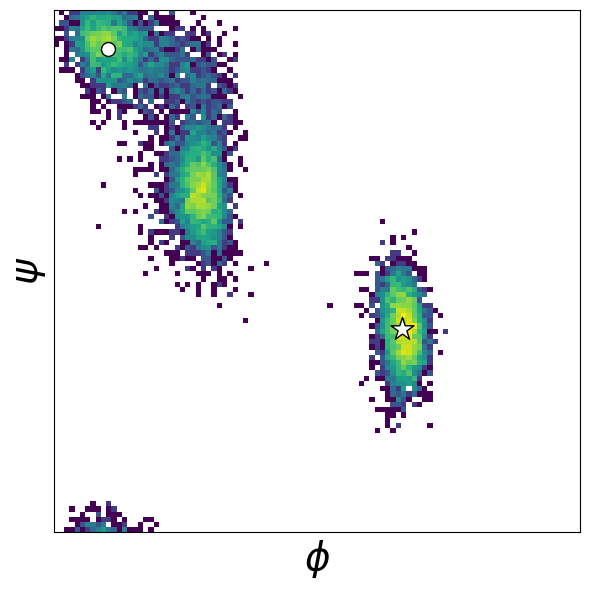

In [15]:
# Load data
phi = np.load(f"{dataset_dir}/current-phi.npy")
psi = np.load(f"{dataset_dir}/current-psi.npy")
print(phi.shape, psi.shape)

fig, ax = plt.subplots(figsize=(6, 6))
plot_range = [-np.pi, np.pi]
h, x_bins, y_bins, im = ax.hist2d(
    phi, psi, 100,
    norm=LogNorm(),
    range=[plot_range,plot_range],
    rasterized=True
)
ax.scatter(c5_phi, c5_psi, edgecolors="black", c="w", zorder=101, s=100)
ax.scatter(c7ax_phi, c7ax_psi, edgecolors="black", c="w", zorder=101, s=300, marker="*")

ax.margins(0) 
ax.tick_params(
	left = False,
	right = False ,
	labelleft = True , 
	labelbottom = True,
	bottom = False
) 
ax.set_xlabel(r"$\phi$", fontsize=FONTSIZE)
ax.set_ylabel(r"$\psi$", fontsize=FONTSIZE)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
# ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
# ax.set_xticklabels([r"$\pi$", r"$\pi/2$", 0, r"$-\pi/2$", r"$-\pi$"], fontsize=FONTSIZE_SMALL)
# ax.set_yticklabels([r"$\pi$", r"$\pi/2$", 0, r"$-\pi/2$", r"$-\pi$"], fontsize=FONTSIZE_SMALL)

fig.tight_layout()
fig.savefig(f"{dataset_dir}/current-ramachandran.pdf", dpi=300)
fig.savefig("./10nano.pdf", dpi=300)


(10000,) (10000,)


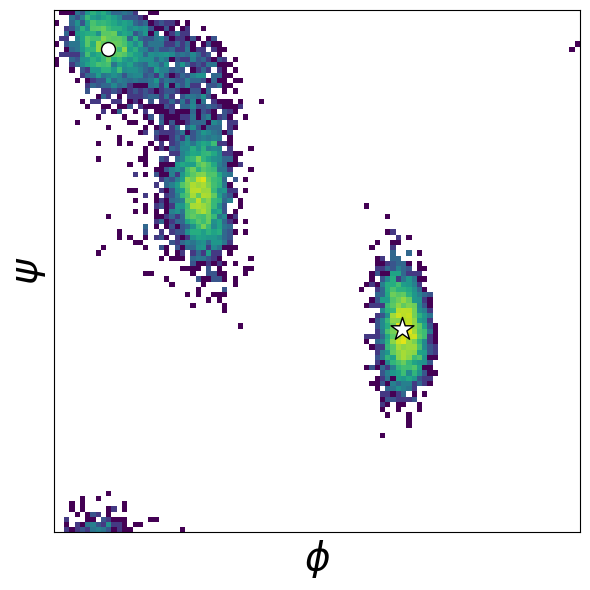

In [16]:
# Load data
phi = np.load(f"{dataset_dir}/timelag-phi.npy")
psi = np.load(f"{dataset_dir}/timelag-psi.npy")
print(phi.shape, psi.shape)

fig, ax = plt.subplots(figsize=(6, 6))
plot_range = [-np.pi, np.pi]
h, x_bins, y_bins, im = ax.hist2d(
    phi, psi, 100,
    norm=LogNorm(),
    range=[plot_range,plot_range],
    rasterized=True
)
ax.scatter(c5_phi, c5_psi, edgecolors="black", c="w", zorder=101, s=100)
ax.scatter(c7ax_phi, c7ax_psi, edgecolors="black", c="w", zorder=101, s=300, marker="*")

ax.margins(0) 
ax.tick_params(
	left = False,
	right = False ,
	labelleft = True , 
	labelbottom = True,
	bottom = False
) 
ax.set_xlabel(r"$\phi$", fontsize=FONTSIZE)
ax.set_ylabel(r"$\psi$", fontsize=FONTSIZE)
ax.set_xticks([])
ax.set_yticks([])

fig.tight_layout()
fig.savefig(f"{dataset_dir}/timelag-ramachandran.pdf", dpi=300)
fig.savefig("./10nano.pdf", dpi=300)


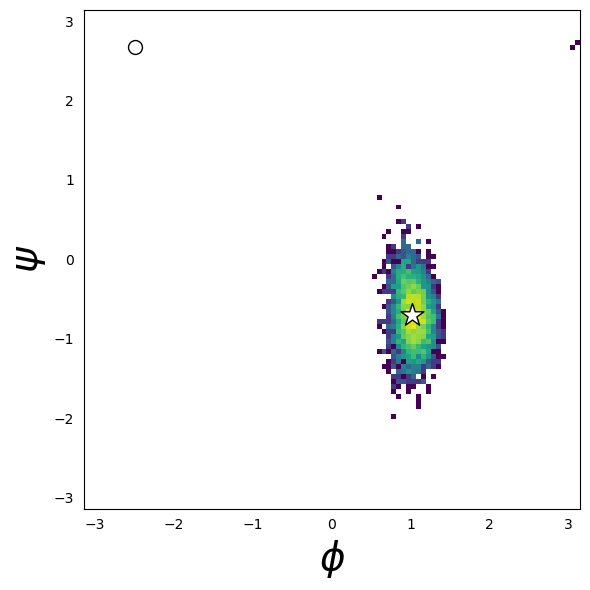

In [27]:
phi_mask = phi > 0
phi_mask

fig, ax = plt.subplots(figsize=(6, 6))
plot_range = [-np.pi, np.pi]
h, x_bins, y_bins, im = ax.hist2d(
    phi[phi_mask], psi[phi_mask], 100,
    norm=LogNorm(),
    range=[plot_range,plot_range],
    rasterized=True
)
ax.scatter(c5_phi, c5_psi, edgecolors="black", c="w", zorder=101, s=100)
ax.scatter(c7ax_phi, c7ax_psi, edgecolors="black", c="w", zorder=101, s=300, marker="*")

ax.margins(0) 
ax.tick_params(
	left = False,
	right = False ,
	labelleft = True , 
	labelbottom = True,
	bottom = False
) 
ax.set_xlabel(r"$\phi$", fontsize=FONTSIZE)
ax.set_ylabel(r"$\psi$", fontsize=FONTSIZE)

fig.tight_layout()

In [26]:
sorted_index_array = np.argsort(phi[phi_mask])[::-1]
print(phi[phi_mask][sorted_index_array])

[3.104765   3.07125    1.4284575  ... 0.5801039  0.57776535 0.516905  ]


## Visualization

In [37]:
frame_idx = -1

phi = np.load(f"{dataset_dir}/current-phi.npy")
psi = np.load(f"{dataset_dir}/current-psi.npy")
print(phi[frame_idx], psi[frame_idx])

pdb_info = md.load(f"../data/{molecule}/c5.pdb")
xyz = torch.load(f"{dataset_dir}/current-xyz-aligned.pt").reshape(-1, 22, 3)

traj = md.Trajectory(xyz.numpy()[frame_idx], pdb_info.topology)
frame_phi = compute_dihedral(xyz.numpy()[frame_idx].reshape(-1, 22, 3)[:, PHI_ANGLE])
frame_psi = compute_dihedral(xyz.numpy()[frame_idx].reshape(-1, 22, 3)[:, PSI_ANGLE])
print(frame_phi, frame_psi)
view = nv.show_mdtraj(traj)
view

1.1493304 -0.2637488
[1.1493301] [-0.26374713]


NGLWidget()

In [49]:
# Sanity check
max_err = 0
max_err_idx = 0

for idx, frame in enumerate(tqdm(xyz)):
    frame_phi = compute_dihedral(frame.reshape(-1, 22, 3)[:, PHI_ANGLE])
    frame_psi = compute_dihedral(frame.reshape(-1, 22, 3)[:, PSI_ANGLE])
    phi_err = phi[idx] - frame_phi
    psi_err = psi[idx] - frame_psi
    if phi_err > 0.1 or psi_err > 0.1:
        print(f"Error at {idx}")
        break
    
    if phi_err > max_err:
        max_err = phi_err
        max_err_idx = idx

print(f"Max error: {max_err} at {max_err_idx}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Max error: 0 at 0


## Transition in dataset

In [2]:
# Check whether transition data exsits
current_data = torch.load(f"{dataset_dir}/current-xyz.pt")
timelag_data = torch.load(f"{dataset_dir}/timelag-xyz.pt")
current_phi = compute_dihedral(current_data.reshape(-1, 22, 3)[:, PHI_ANGLE])
timelag_phi = compute_dihedral(timelag_data.reshape(-1, 22, 3)[:, PHI_ANGLE])
print(current_phi.shape, timelag_phi.shape)

(10000,) (10000,)


In [3]:
phi_opposite_mask = current_phi * timelag_phi < 0
phi_opposite_mask.sum()

2

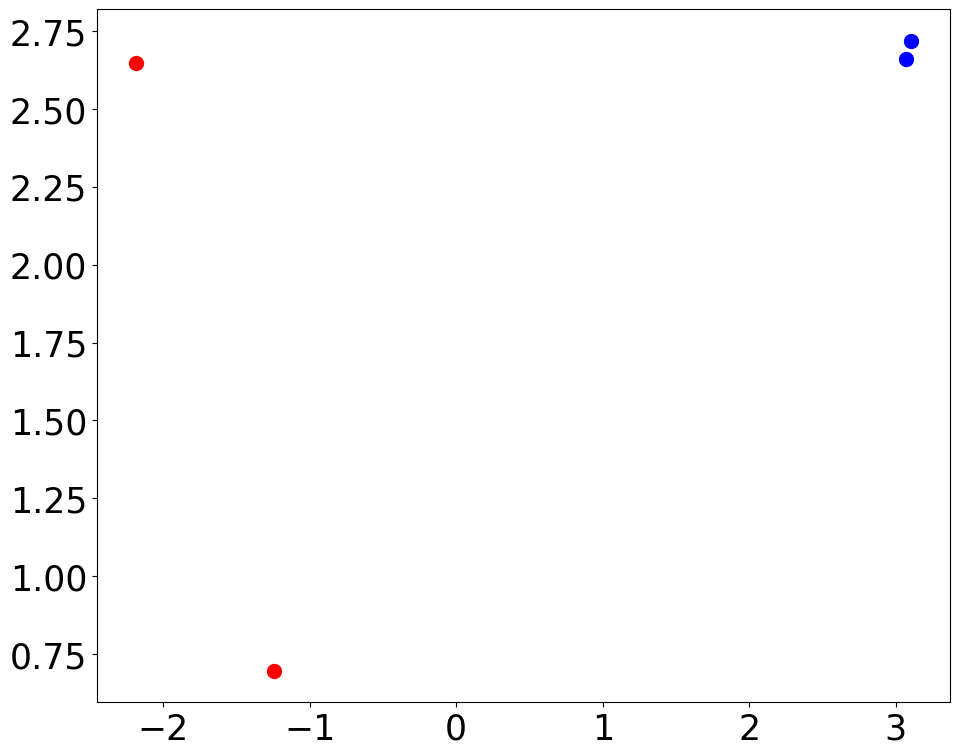

In [8]:
transition_idx = np.where(phi_opposite_mask)[0]
transition_data_current = current_data[transition_idx]
transition_data_timelag = timelag_data[transition_idx]
transition_data_current_phi = compute_dihedral(transition_data_current.reshape(-1, 22, 3)[:, PHI_ANGLE])
transition_data_timelag_phi = compute_dihedral(transition_data_timelag.reshape(-1, 22, 3)[:, PHI_ANGLE])
transition_data_current_psi = compute_dihedral(transition_data_current.reshape(-1, 22, 3)[:, PSI_ANGLE])
transition_data_timelag_psi = compute_dihedral(transition_data_timelag.reshape(-1, 22, 3)[:, PSI_ANGLE])

fig, ax = plt.subplots(figsize=(11, 9))
plot_range = [-3.2, 3.2]
# h, x_bins, y_bins, im = ax.hist2d(phi, psi, 100, norm=LogNorm(), range=[plot_range,plot_range],rasterized=True)
ax.scatter(transition_data_current_phi, transition_data_current_psi, color="red", s=100, label="current")
ax.scatter(transition_data_timelag_phi, transition_data_timelag_psi, color="blue", s=100, label="timelag")
# ticks = np.array([np.exp(-6)*h.max(), np.exp(-4.0)*h.max(),np.exp(-2)*h.max(), h.max()])
# ax.set_xlabel(r"$\varphi$", fontsize=45)
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=25)
# cbar = fig.colorbar(im, ticks=ticks)
# cbar.ax.set_yticklabels([6.0,4.0,2.0,0.0], fontsize=25)
# cbar.ax.invert_yaxis()


# Distance distribution

In [51]:
dataset = torch.load(f"../dataset/{molecule}/{temperature}/{version}/cl-distance.pt")

In [52]:
state_list = []
positive_list = []
negative_list = []

for data in tqdm(dataset):
	current_state, positive, negative, _, _ = data
	state_list.append(current_state)
	positive_list.append(positive)
	negative_list.append(negative)

  0%|          | 0/4000000 [00:00<?, ?it/s]

In [53]:
state_list = np.stack(state_list)
positive_list = np.stack(positive_list)
negative_list = np.stack(negative_list)

print(state_list.shape, positive_list.shape, negative_list.shape)

(4000000, 45) (4000000, 45) (4000000, 45)


<Figure size 640x480 with 0 Axes>

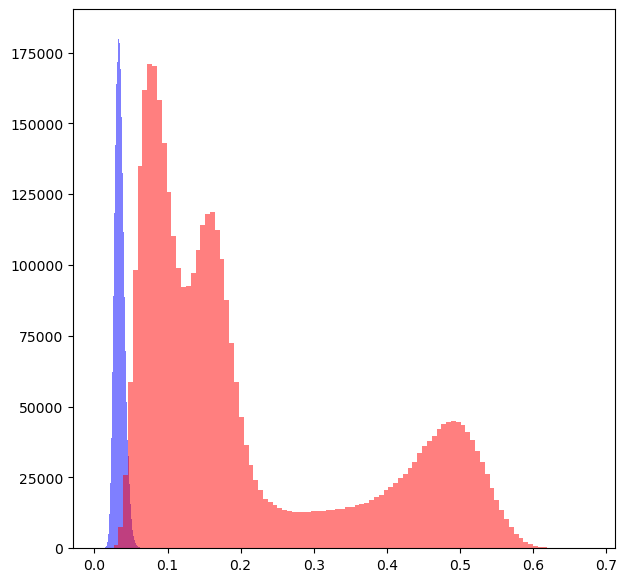

In [54]:
positive_distance_list = np.linalg.norm(positive_list - state_list, axis=1)
negative_distance_list = np.linalg.norm(negative_list - state_list, axis=1)

plt.clf()
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.hist(positive_distance_list, bins=100, alpha=0.5, color="blue", label="Positive")
ax.hist(negative_distance_list, bins=100, alpha=0.5, color="red", label="Negative")
plt.show()